In [5]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sns.set(style="whitegrid")
# QALD9Plus-MT_ru-spacy_ner-mgenre_el-mbart_mt

In [9]:
df_kgqa = pd.read_csv("../data/Lingua Franca KGQA Experiments - mainTable.tsv", sep="\t")

In [12]:
df_kgqa["System"] = df_kgqa["System"].apply(lambda x: str(x).split("(")[0].replace("NIFWS_", ""))
df_kgqa["srcLang"] = df_kgqa["Dataset"].apply(lambda x: str(x).split("-")[1].replace("MT_", "") if "-" in str(x) else "remove")
df_kgqa["split"] = df_kgqa["Dataset"].apply(lambda x: str(x).split("-")[0] if "-" in str(x) else "remove")
df_kgqa["pipeline"] = df_kgqa["Dataset"].apply(lambda x: "-".join(s for s in str(x).split("-")[-3:]) if "-" in str(x) else "remove")
df_kgqa["mtTool"] = df_kgqa["Dataset"].apply(lambda x: str(x).split("-")[-1] if "-" in str(x) else "remove")
df_kgqa["isStdMtTool"] = df_kgqa["pipeline"].apply(lambda x: True if "no_" in str(x) else False)

In [13]:
df_kgqa = df_kgqa[df_kgqa["srcLang"] != "remove"]
df_kgqa = df_kgqa[df_kgqa["System"].isin(["QAnswer", "Qanary_1", "Qanary_3"])]

In [14]:
df_kgqa.head()

,Dataset,System,MicroF1,MacroF1,MicroPrecision,MacroPrecision,MicroRecall,MacroRecall,QALD-F1,Timestamp,ExperimentURI,srcLang,split,pipeline,mtTool,isStdMtTool
8,QALD9Plus-MT_ru-babelscape_ner-mgenre_el-libre_mt,QAnswer,0.030929,0.211339,0.021148,0.227331,0.057537,0.265158,0.290282,2022-09-27 23:42:33,http://gerbil-qa.aksw.org/gerbil/experiment?id...,ru,QALD9Plus,babelscape_ner-mgenre_el-libre_mt,libre_mt,False
9,QALD9Plus-MT_ru-no_ner-no_el-libre_mt,QAnswer,0.031480,0.185895,0.019061,0.199315,0.090341,0.242115,0.277858,2022-09-27 23:42:33,http://gerbil-qa.aksw.org/gerbil/experiment?id...,ru,QALD9Plus,no_ner-no_el-libre_mt,libre_mt,True
12,QALD9PlusTrain-MT_fr-no_ner-no_el-libre_mt,QAnswer,0.042483,0.220828,0.040079,0.214674,0.045194,0.296712,0.322697,2022-09-28 21:57:20,http://gerbil-qa.aksw.org/gerbil/experiment?id...,fr,QALD9PlusTrain,no_ner-no_el-libre_mt,libre_mt,True
13,QALD9PlusTrain-MT_fr-no_ner-no_el-libre_mt,QAnswer,0.043731,0.215992,0.042503,0.210243,0.045031,0.287059,0.327102,2022-09-28 22:15:51,http://gerbil-qa.aksw.org/gerbil/experiment?id...,fr,QALD9PlusTrain,no_ner-no_el-libre_mt,libre_mt,True
14,QALD9PlusTrain-MT_fr-no_ner-no_el-libre_mt,QAnswer,0.042640,0.222986,0.041075,0.218689,0.044328,0.297601,0.313260,2022-09-29 00:12:46,http://gerbil-qa.aksw.org/gerbil/experiment?id...,fr,QALD9PlusTrain,no_ner-no_el-libre_mt,libre_mt,True


In [15]:
# get highest non-std mt tool
df_kgqa[(df_kgqa["split"] == "QALD9Plus") & (df_kgqa["srcLang"] == "de") & (df_kgqa["mtTool"] == "libre_mt") & (df_kgqa["isStdMtTool"] == True)].groupby(["pipeline"]).aggregate({"MacroF1": "mean"}).reset_index().sort_values("MacroF1", ascending=False).iloc[0]

pipeline    no_ner-no_el-libre_mt
MacroF1                  0.240027
Name: 0, dtype: object

In [16]:
splits = df_kgqa.split.unique()
langs = sorted(df_kgqa.srcLang.unique())
mtTools = df_kgqa.mtTool.unique()

df_dict = {"split": [], "lang": [], "mtTool": [], "pipeline": [], "MacroF1": []}

for i, split in enumerate(splits):
    for j, lang in enumerate(langs):
        df = df_kgqa[(df_kgqa["split"] == split) & (df_kgqa["srcLang"] == lang)]
        
        for mtTool in mtTools:
            # get highest non-std pipeline
            row = df_kgqa[(df_kgqa["split"] == split) & (df_kgqa["srcLang"] == lang) & (df_kgqa["mtTool"] == mtTool) & (df_kgqa["isStdMtTool"] == False)].groupby(["pipeline"]).aggregate({"MacroF1": "mean"}).reset_index().sort_values("MacroF1", ascending=False).iloc[0]
            bestPipeline = row["pipeline"]
            pipelineScore = row["MacroF1"]

            df_dict["split"].append(split)
            df_dict["lang"].append(lang)
            df_dict["mtTool"].append(mtTool)
            df_dict["pipeline"].append(bestPipeline)
            df_dict["MacroF1"].append(pipelineScore)

            # get std mt tool
            row = df_kgqa[(df_kgqa["split"] == split) & (df_kgqa["srcLang"] == lang) & (df_kgqa["mtTool"] == mtTool) & (df_kgqa["isStdMtTool"] == True)].groupby(["pipeline"]).aggregate({"MacroF1": "mean"}).reset_index().sort_values("MacroF1", ascending=False).iloc[0]
            stdMtTool = row["pipeline"]
            stdMtToolScore = row["MacroF1"]

            df_dict["split"].append(split)
            df_dict["lang"].append(lang)
            df_dict["mtTool"].append(mtTool)
            df_dict["pipeline"].append(stdMtTool)
            df_dict["MacroF1"].append(stdMtToolScore)

In [17]:
vis_df = pd.DataFrame.from_dict(df_dict)
# vis_df.head()

/tmp/ipykernel_8049/956003977.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mtTool"] = df["mtTool"].apply(lambda x: x.replace("_", " ").upper())
/tmp/ipykernel_8049/956003977.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pipelineType"] = df["pipeline"].apply(lambda x: "Standard MT" if "no_" in x else "Lingua Franca")
/tmp/ipykernel_8049/956003977.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

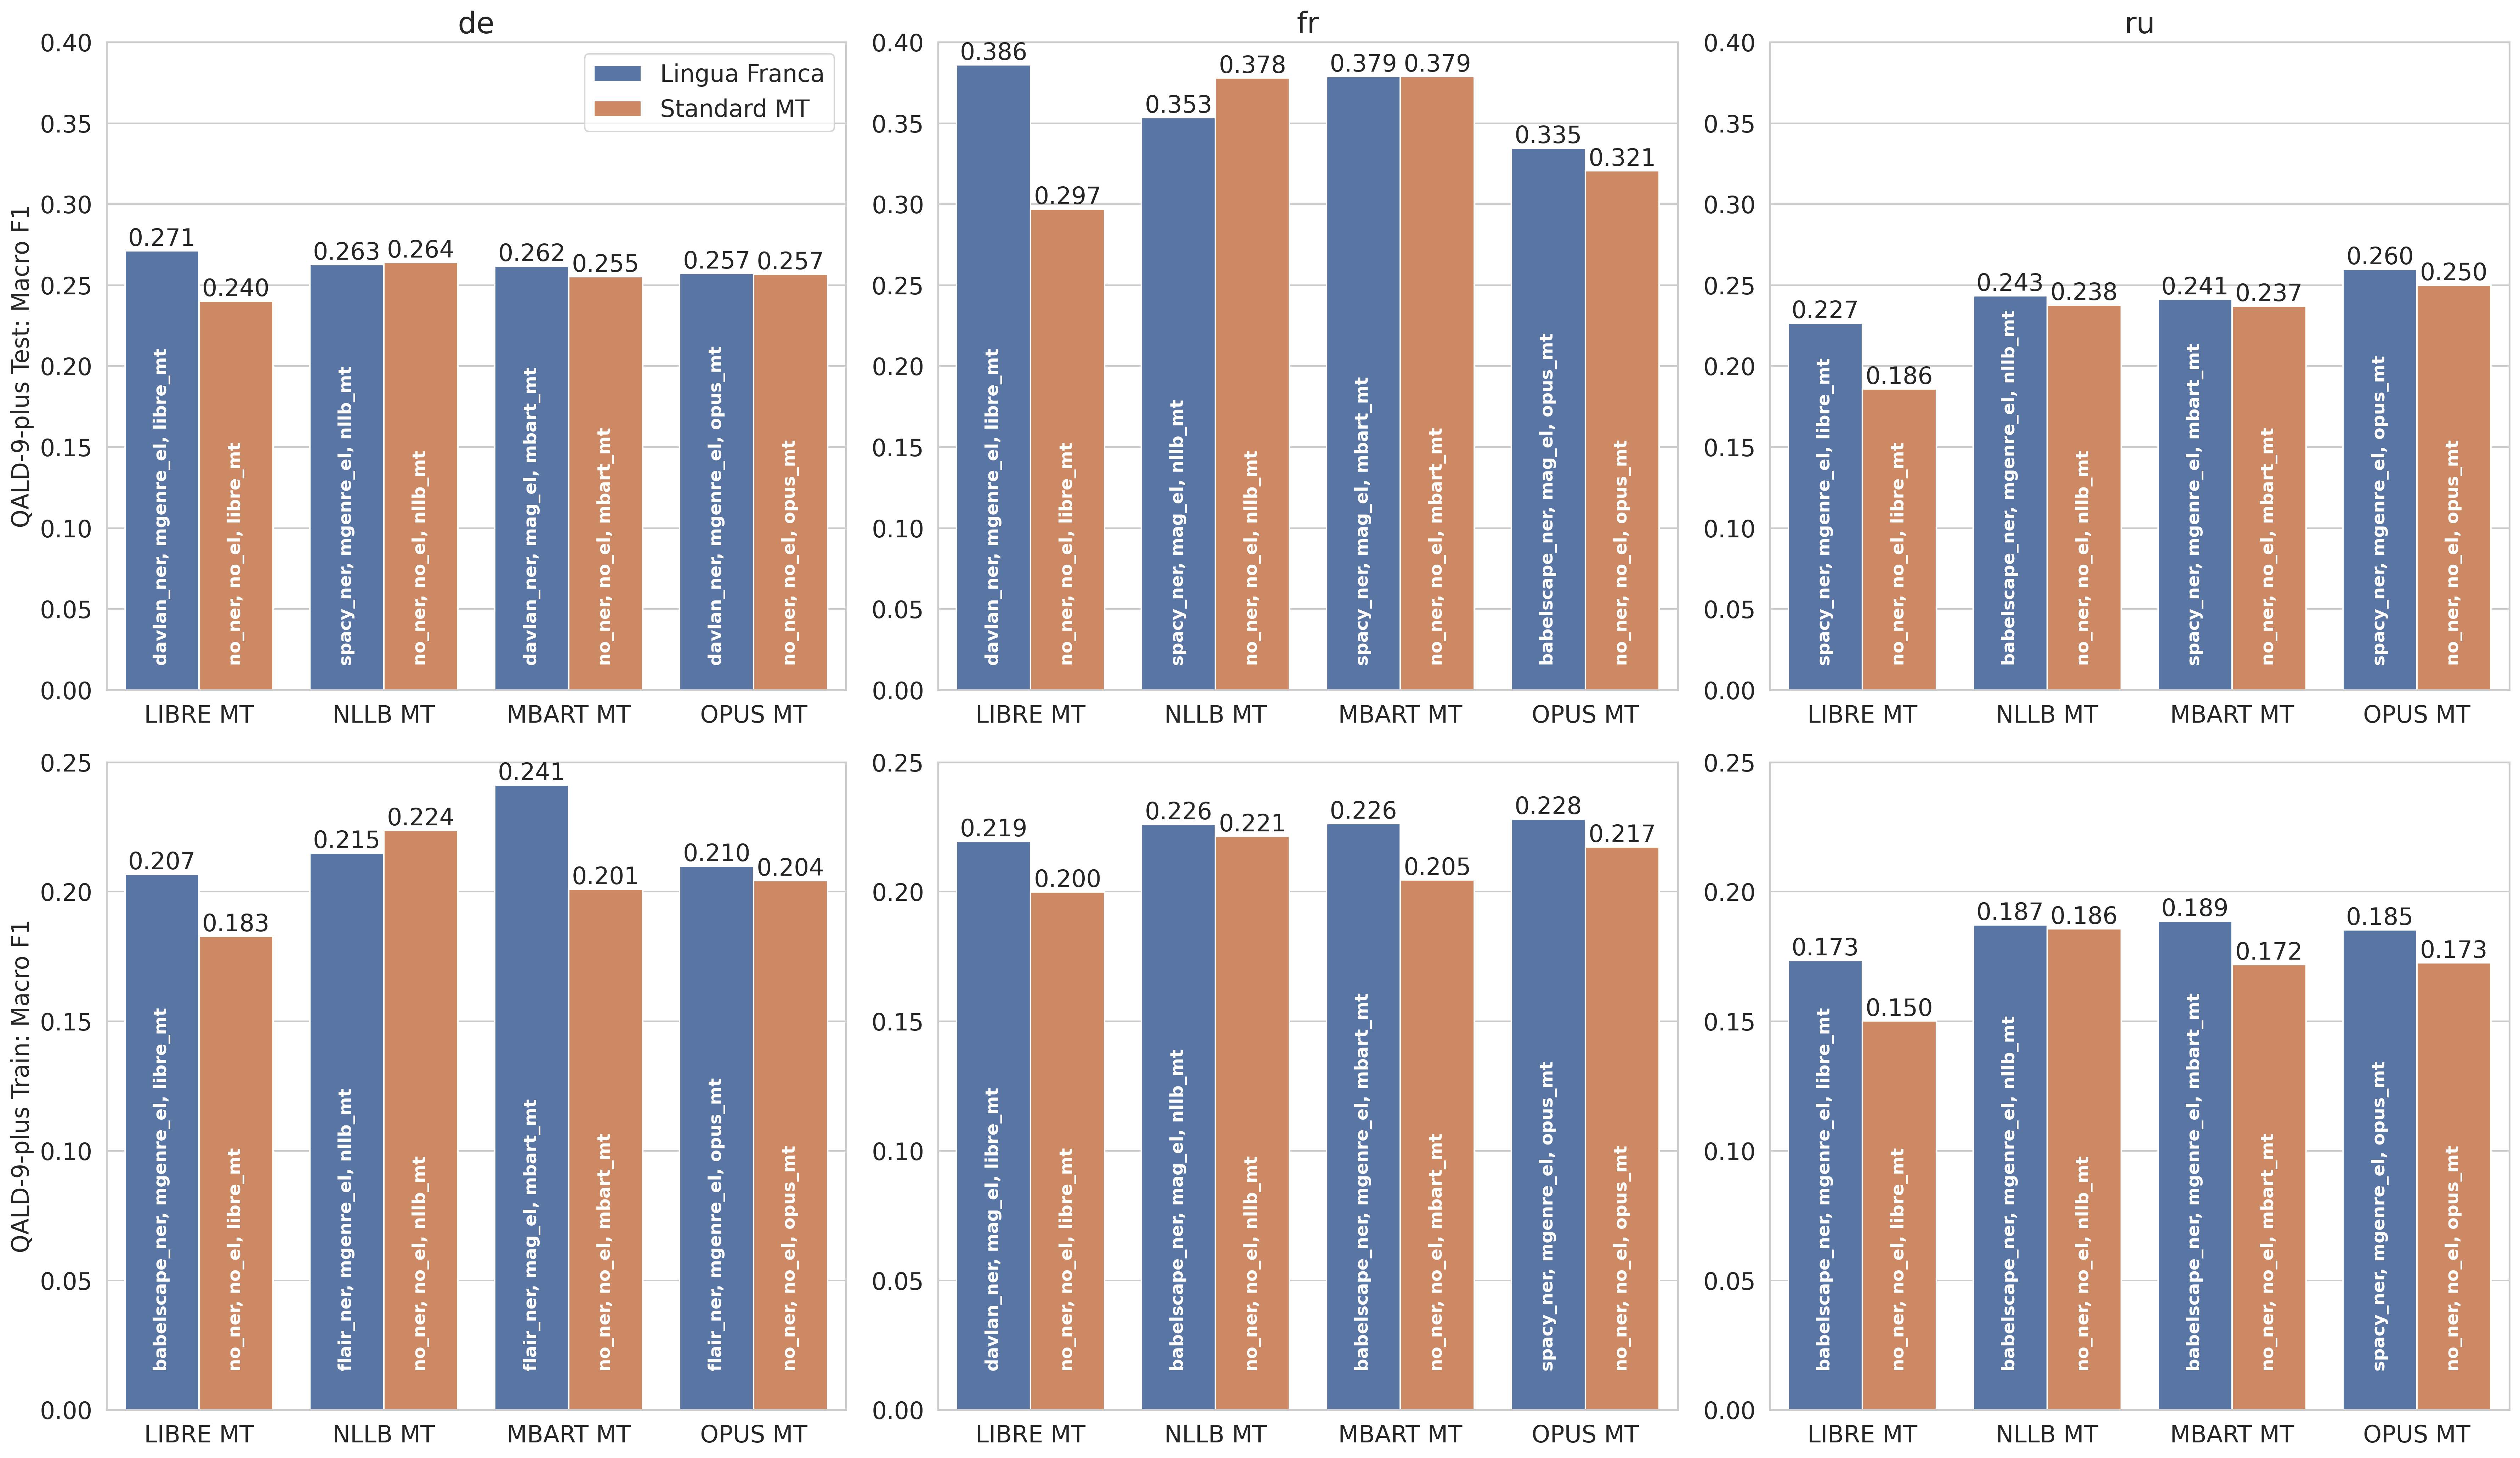

In [26]:
from numpy import size


plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20

fig, axs = plt.subplots(nrows=len(splits), ncols=len(langs), figsize=(24, 14), dpi=300)
ymax = [0.4, 0.25]

for i, split in enumerate(splits):
    for j, lang in enumerate(langs):
        df = vis_df[(vis_df["split"] == split) & (vis_df["lang"] == lang)]
        
        df["mtTool"] = df["mtTool"].apply(lambda x: x.replace("_", " ").upper())
        df["pipelineType"] = df["pipeline"].apply(lambda x: "Standard MT" if "no_" in x else "Lingua Franca")
        ax = sns.barplot(data=df, x="mtTool", y="MacroF1", hue="pipelineType", ax=axs[i][j])

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f')
        
        if i == 0:
            ax.set_title(f"{lang}")
        else:
            ax.set_title("")

        ax.set_ylim(0, ymax[i])
        if j > 0:
            ax.set_ylabel("")
        else:
            if "train" in splits[i].lower():
                ax.set_ylabel(f"QALD-9-plus Train: Macro F1")
            else:
                ax.set_ylabel(f"QALD-9-plus Test: Macro F1")

        ax.set_xlabel("")
        # ax.set_xticks([0.1,1,2,3], va="center")
        #ax.set_xticklabels(ax.get_xticklabels(), ha="left")
        #ax.tick_params(axis='x', which='major', grid_linewidth=5)
        # ax.set_xticks([0.0,1,2,3])
        # ax.margins(x=0.1)
        x_coordinates = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8 ,3.2]
        for k, p in enumerate(df.pipeline.values.tolist()):
            p_text = ', '.join(comp for comp in p.split("-"))
            ax.text(x_coordinates[k], 0.015, p_text, rotation=90, color='white', size=12, ha="center", va="bottom", weight='bold')
            
        if not (i == 0 and j == 0):
            ax.legend().remove()
        else:
            ax.legend().set_title("Type")
            ax.legend(fontsize=16)

plt.tight_layout()
plt.savefig('../data/img/grouped-bar-plot.pdf')

# Wilcoxon test

In [19]:
from scipy.stats import wilcoxon

In [20]:
df = pd.DataFrame()
for i, split in enumerate(splits):
    for j, lang in enumerate(langs):
        df_ = vis_df[(vis_df["split"] == split) & (vis_df["lang"] == lang)]
        
        df_["mtTool"] = df_["mtTool"].apply(lambda x: x.replace("_", " ").upper())
        df_["pipelineType"] = df_["pipeline"].apply(lambda x: "Standard MT" if "no_" in x else "Lingua Franca")

        if df.shape[0] > 0:
            df = df.append(df_)
        else:
            df = df_

/tmp/ipykernel_8049/116744807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["mtTool"] = df_["mtTool"].apply(lambda x: x.replace("_", " ").upper())
/tmp/ipykernel_8049/116744807.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["pipelineType"] = df_["pipeline"].apply(lambda x: "Standard MT" if "no_" in x else "Lingua Franca")
/tmp/ipykernel_8049/116744807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [21]:
x = df[df["pipelineType"] == "Standard MT"]["MacroF1"].values
y = df[df["pipelineType"] == "Lingua Franca"]["MacroF1"].values

In [22]:
wilcoxon(x, y)

WilcoxonResult(statistic=33.0, pvalue=0.0008292057593073193)